# Peru en el Contexto Latinoamericano: Analisis de Indicadores de Desarrollo
## World Bank API (2015-2023) | Pre, Durante y Post COVID-19

**Curso:** Lenguaje de Programacion 2  
**Universidad:** UNALM  
**Integrantes:** 
1. Javier Anthony Uraco Silva
2. Fiorella Fuentes Bueno
3. Kesdine Yasmin Palma Cruz
4. Brayan Augusto Flores Villa
5. Sebastian Samuel Fernandez Andrade
6. Estiven Aldair Mata Sotelo
7. Arlette Alashka Carmen Tullume

---

## Objetivo
Analizar la posicion de **Peru** en comparacion con otros paises de Latinoamerica en indicadores clave de desarrollo economico, social y de infraestructura, con enfasis especial en el impacto del COVID-19.

## Periodo de analisis
| Fase | Años | Descripcion |
|------|------|-------------|
| Pre-COVID | 2015-2019 | Situacion antes de la pandemia |
| COVID | 2020-2021 | Impacto de la pandemia |
| Post-COVID | 2022-2023 | Recuperacion economica |

## Fuente de datos
- **API:** World Bank Open Data
- **URL:** https://api.worldbank.org/v2/

## Paises analizados
| Pais | Codigo | Rol en el analisis |
|------|--------|--------------------|
| **Peru** | PE | **Pais principal** |
| Chile | CL | Comparacion |
| Colombia | CO | Comparacion |
| Ecuador | EC | Comparacion |
| Bolivia | BO | Comparacion |
| Brasil | BR | Comparacion |
| Argentina | AR | Comparacion |

---
## 1. Importar librerias

In [69]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Colores: Peru destacado en rojo
COLORES_PAISES = {
    'Peru': '#E63946',
    'Chile': '#457B9D',
    'Colombia': '#2A9D8F',
    'Ecuador': '#E9C46A',
    'Bolivia': '#F4A261',
    'Brazil': '#264653',
    'Argentina': '#8338EC'
}

print("Librerias cargadas correctamente")

Librerias cargadas correctamente


---
## 2. Configuracion de paises e indicadores

In [70]:
# Paises a analizar (Peru como principal)
PAISES = {
    'PE': 'Peru',
    'CL': 'Chile',
    'CO': 'Colombia',
    'EC': 'Ecuador',
    'BO': 'Bolivia',
    'BR': 'Brazil',
    'AR': 'Argentina'
}

# Indicadores del World Bank
INDICADORES = {
    'NY.GDP.PCAP.CD': 'PBI per capita (USD)',
    'NY.GDP.MKTP.KD.ZG': 'Crecimiento del PBI (%)',
    'FP.CPI.TOTL.ZG': 'Inflacion (%)',
    'SI.POV.GINI': 'Indice GINI',
    'SE.XPD.TOTL.GD.ZS': 'Gasto en educacion (% del PBI)',
    'SP.DYN.LE00.IN': 'Esperanza de vida (anios)',
    'SH.XPD.CHEX.GD.ZS': 'Gasto en salud (% del PBI)',
    'SP.DYN.IMRT.IN': 'Mortalidad infantil (por 1000)',
    'NV.AGR.TOTL.ZS': 'Agricultura (% del PBI)',
    'SL.AGR.EMPL.ZS': 'Empleo agricola (%)',
    'IT.NET.USER.ZS': 'Usuarios de internet (%)',
    'EG.ELC.ACCS.ZS': 'Acceso a electricidad (%)'
}

# Periodo de analisis
FECHA_INICIO = 2015
FECHA_FIN = 2023

print(f"Pais principal: PERU")
print(f"Paises de comparacion: {len(PAISES) - 1}")
print(f"Indicadores: {len(INDICADORES)}")
print(f"Periodo: {FECHA_INICIO} - {FECHA_FIN}")

Pais principal: PERU
Paises de comparacion: 6
Indicadores: 12
Periodo: 2015 - 2023


---
## 3. Funciones de extraccion de datos

In [71]:
def obtener_datos_worldbank(paises, indicador, fecha_inicio, fecha_fin):
    """
    Extrae datos de la API del World Bank para multiples paises.
    """
    codigos = ';'.join(paises.keys())
    url = f"https://api.worldbank.org/v2/country/{codigos}/indicator/{indicador}"
    
    params = {
        'format': 'json',
        'date': f'{fecha_inicio}:{fecha_fin}',
        'per_page': 1000
    }
    
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if len(data) < 2 or data[1] is None:
            return pd.DataFrame()
        
        registros = []
        for item in data[1]:
            registros.append({
                'pais_codigo': item['country']['id'],
                'pais': item['country']['value'],
                'anio': int(item['date']),
                'valor': item['value'],
                'indicador_codigo': item['indicator']['id'],
                'indicador': item['indicator']['value']
            })
        
        return pd.DataFrame(registros)
    
    except requests.exceptions.RequestException as e:
        print(f"Error al obtener {indicador}: {e}")
        return pd.DataFrame()


def extraer_todos_indicadores(paises, indicadores, fecha_inicio, fecha_fin):
    """
    Extrae todos los indicadores para todos los paises.
    """
    lista_dfs = []
    
    print("Iniciando extraccion de datos...\n")
    
    for codigo, nombre in indicadores.items():
        print(f"Extrayendo: {nombre}...")
        df = obtener_datos_worldbank(paises, codigo, fecha_inicio, fecha_fin)
        
        if not df.empty:
            lista_dfs.append(df)
            print(f"   {len(df)} registros obtenidos")
        else:
            print(f"   Sin datos disponibles")
        
        time.sleep(0.5)
    
    if lista_dfs:
        df_completo = pd.concat(lista_dfs, ignore_index=True)
        print(f"\n{'='*50}")
        print(f"Extraccion completada: {len(df_completo)} registros totales")
        return df_completo
    else:
        return pd.DataFrame()


def agregar_fase_covid(df):
    """
    Agrega columna con la fase COVID (Pre, Durante, Post)
    """
    def clasificar_fase(anio):
        if anio <= 2019:
            return 'Pre-COVID (2015-2019)'
        elif anio <= 2021:
            return 'COVID (2020-2021)'
        else:
            return 'Post-COVID (2022-2023)'
    
    df['fase_covid'] = df['anio'].apply(clasificar_fase)
    return df


print("Funciones de extraccion definidas")

Funciones de extraccion definidas


---
## 4. Extraccion de datos

In [72]:
# Extraer todos los datos
df_completo = extraer_todos_indicadores(PAISES, INDICADORES, FECHA_INICIO, FECHA_FIN)

# Agregar fase COVID
df_completo = agregar_fase_covid(df_completo)

Iniciando extraccion de datos...

Extrayendo: PBI per capita (USD)...
   63 registros obtenidos
Extrayendo: Crecimiento del PBI (%)...
   63 registros obtenidos
Extrayendo: Inflacion (%)...
   63 registros obtenidos
Extrayendo: Indice GINI...
   63 registros obtenidos
Extrayendo: Gasto en educacion (% del PBI)...
   63 registros obtenidos
Extrayendo: Esperanza de vida (anios)...
   63 registros obtenidos
Extrayendo: Gasto en salud (% del PBI)...
   63 registros obtenidos
Extrayendo: Mortalidad infantil (por 1000)...
   63 registros obtenidos
Extrayendo: Agricultura (% del PBI)...
   63 registros obtenidos
Extrayendo: Empleo agricola (%)...
   63 registros obtenidos
Extrayendo: Usuarios de internet (%)...
   63 registros obtenidos
Extrayendo: Acceso a electricidad (%)...
   63 registros obtenidos

Extraccion completada: 756 registros totales


In [73]:
# Informacion del dataset
print(f"Dimensiones: {df_completo.shape[0]} filas x {df_completo.shape[1]} columnas")
print(f"Anios: {df_completo['anio'].min()} - {df_completo['anio'].max()}")
print(f"Paises: {df_completo['pais'].nunique()}")
print(f"Indicadores: {df_completo['indicador_codigo'].nunique()}")
print(f"\nRegistros por fase COVID:")
print(df_completo['fase_covid'].value_counts())

Dimensiones: 756 filas x 7 columnas
Anios: 2015 - 2023
Paises: 7
Indicadores: 12

Registros por fase COVID:
fase_covid
Pre-COVID (2015-2019)     420
Post-COVID (2022-2023)    168
COVID (2020-2021)         168
Name: count, dtype: int64


In [74]:
# Ver primeras filas
df_completo.head(10)

,pais_codigo,pais,anio,valor,indicador_codigo,indicador,fase_covid
0,AR,Argentina,2023,14261.846567,NY.GDP.PCAP.CD,GDP per capita (current US$),Post-COVID (2022-2023)
1,AR,Argentina,2022,13962.189409,NY.GDP.PCAP.CD,GDP per capita (current US$),Post-COVID (2022-2023)
2,AR,Argentina,2021,10738.017922,NY.GDP.PCAP.CD,GDP per capita (current US$),COVID (2020-2021)
3,AR,Argentina,2020,8535.599380,NY.GDP.PCAP.CD,GDP per capita (current US$),COVID (2020-2021)
4,AR,Argentina,2019,9955.974787,NY.GDP.PCAP.CD,GDP per capita (current US$),Pre-COVID (2015-2019)
5,AR,Argentina,2018,11752.799892,NY.GDP.PCAP.CD,GDP per capita (current US$),Pre-COVID (2015-2019)
6,AR,Argentina,2017,14532.500931,NY.GDP.PCAP.CD,GDP per capita (current US$),Pre-COVID (2015-2019)
7,AR,Argentina,2016,12699.962314,NY.GDP.PCAP.CD,GDP per capita (current US$),Pre-COVID (2015-2019)
8,AR,Argentina,2015,13679.626498,NY.GDP.PCAP.CD,GDP per capita (current US$),Pre-COVID (2015-2019)
9,BO,Bolivia,2023,4274.708205,NY.GDP.PCAP.CD,GDP per capita (current US$),Post-COVID (2022-2023)


---
## 5. Guardar datos en CSV

In [75]:
# Guardar dataset completo
df_completo.to_csv('datos_worldbank_peru_latam.csv', index=False, encoding='utf-8')
print("Guardado: 'datos_worldbank_peru_latam.csv'")

Guardado: 'datos_worldbank_peru_latam.csv'


---
## 6. Funciones de analisis y visualizacion

In [76]:
def graficar_indicador_peru_destacado(df, indicador_codigo, titulo, ylabel, invertir=False):
    """
    Grafica un indicador destacando a Peru en rojo.
    """
    df_ind = df[df['indicador_codigo'] == indicador_codigo].copy()
    df_ind = df_ind.dropna(subset=['valor'])
    
    if df_ind.empty:
        print(f"No hay datos para {titulo}")
        return None
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Graficar otros paises primero
    for pais in df_ind['pais'].unique():
        datos_pais = df_ind[df_ind['pais'] == pais].sort_values('anio')
        color = COLORES_PAISES.get(pais, 'gray')
        
        if pais == 'Peru':
            continue
        
        ax.plot(datos_pais['anio'], datos_pais['valor'], 
                marker='o', linewidth=1.5, markersize=4, 
                label=pais, color=color, alpha=0.7)
    
    # Graficar Peru al final (destacado)
    datos_peru = df_ind[df_ind['pais'] == 'Peru'].sort_values('anio')
    if not datos_peru.empty:
        ax.plot(datos_peru['anio'], datos_peru['valor'], 
                marker='o', linewidth=3, markersize=8, 
                label='PERU', color='#E63946', zorder=5)
    
    # Zona COVID
    ax.axvline(x=2020, color='gray', linestyle='--', alpha=0.5, linewidth=2)
    ax.axvspan(2020, 2021, alpha=0.1, color='red', label='Periodo COVID')
    
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.set_xlabel('Año', fontsize=12)  # ← CORREGIDO AQUÍ
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(FECHA_INICIO, FECHA_FIN + 1))
    
    if invertir:
        ax.invert_yaxis()
    
    plt.tight_layout()
    return fig


print("Funciones de analisis definidas")


Funciones de analisis definidas


---
## 7. ECONOMIA: PBI per capita

### 7.1 Evolucion del PBI per capita

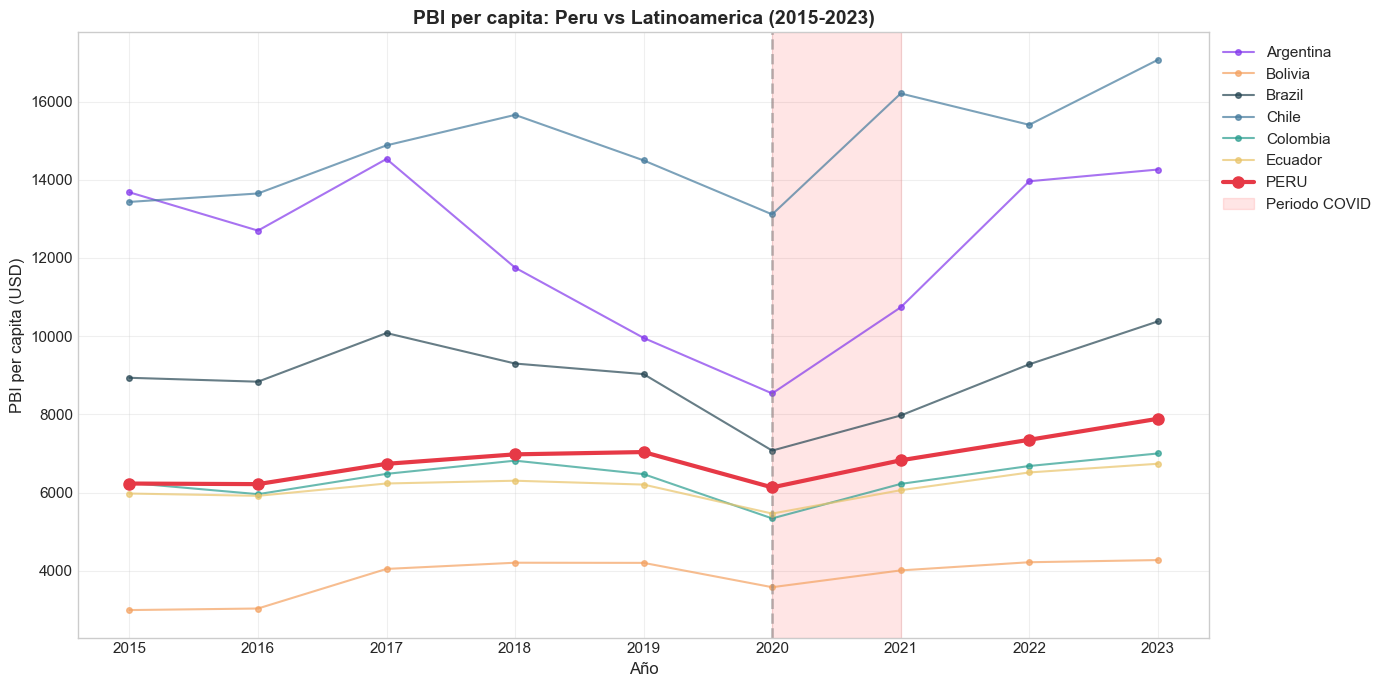

Grafico guardado: 'grafico_pbi_peru.png'


In [77]:
fig = graficar_indicador_peru_destacado(
    df_completo, 
    'NY.GDP.PCAP.CD', 
    'PBI per capita: Peru vs Latinoamerica (2015-2023)',
    'PBI per capita (USD)'
)
if fig:
    plt.savefig('grafico_pbi_peru.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Grafico guardado: 'grafico_pbi_peru.png'")

### 7.2 Crecimiento del PBI

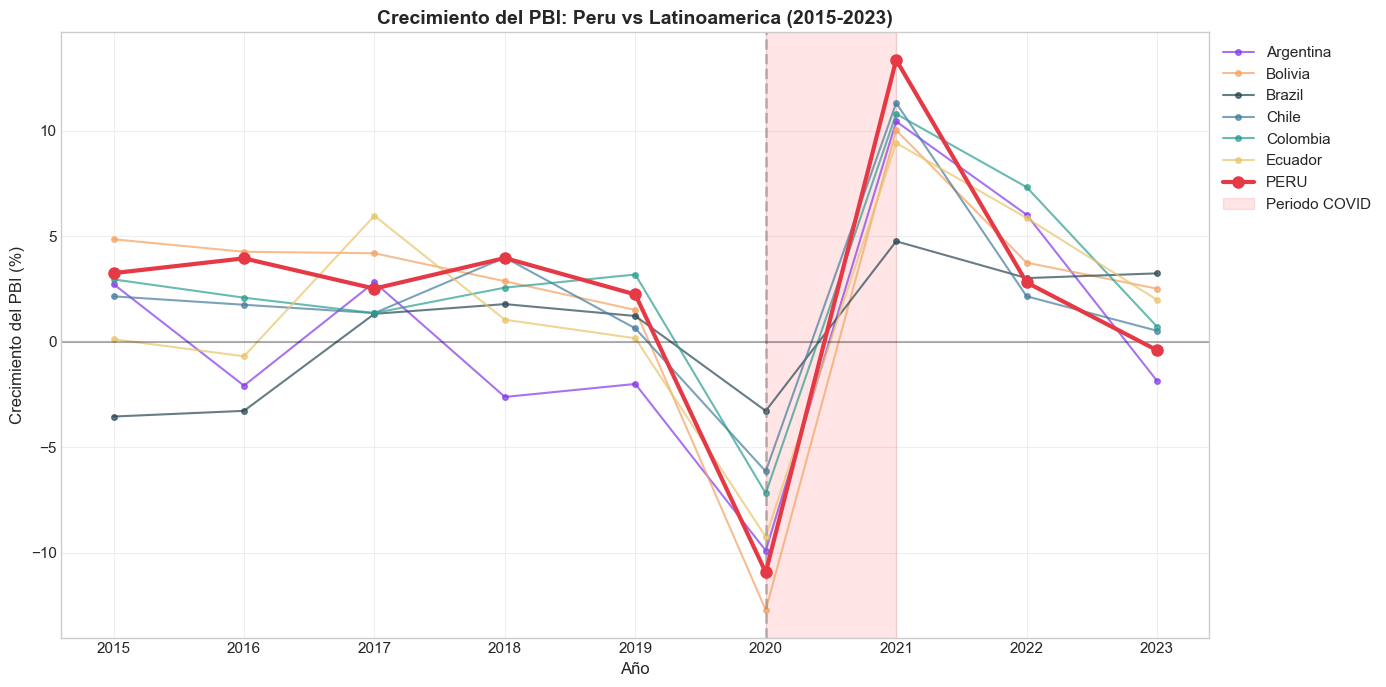

Grafico guardado: 'grafico_crecimiento_peru.png'


In [78]:
fig = graficar_indicador_peru_destacado(
    df_completo, 
    'NY.GDP.MKTP.KD.ZG', 
    'Crecimiento del PBI: Peru vs Latinoamerica (2015-2023)',
    'Crecimiento del PBI (%)'
)
if fig:
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.savefig('grafico_crecimiento_peru.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Grafico guardado: 'grafico_crecimiento_peru.png'")

---
## 8. ANALISIS PRE vs POST COVID

### 8.1 Impacto del COVID en el PBI - Grafico de barras

In [79]:
# Comparar crecimiento del PBI: 2019 vs 2020
df_crecimiento = df_completo[df_completo['indicador_codigo'] == 'NY.GDP.MKTP.KD.ZG'].copy()
df_crecimiento = df_crecimiento.dropna(subset=['valor'])

# Pivot para comparar anios
df_covid_impact = df_crecimiento[df_crecimiento['anio'].isin([2019, 2020, 2021, 2022, 2023])]
df_pivot_covid = df_covid_impact.pivot_table(index='pais', columns='anio', values='valor').round(2)

# Calcular caida en 2020 y recuperacion
if 2019 in df_pivot_covid.columns and 2020 in df_pivot_covid.columns:
    df_pivot_covid['Caida_2020'] = df_pivot_covid[2020] - df_pivot_covid[2019]
if 2020 in df_pivot_covid.columns and 2021 in df_pivot_covid.columns:
    df_pivot_covid['Rebote_2021'] = df_pivot_covid[2021] - df_pivot_covid[2020]

df_pivot_covid = df_pivot_covid.sort_values('Caida_2020' if 'Caida_2020' in df_pivot_covid.columns else 2020)

print("IMPACTO DEL COVID-19 EN EL CRECIMIENTO DEL PBI")
print("="*60)
display(df_pivot_covid)

IMPACTO DEL COVID-19 EN EL CRECIMIENTO DEL PBI


anio,2019,2020,2021,2022,2023,Caida_2020,Rebote_2021
pais,,,,,,,
Bolivia,1.51,-12.72,10.03,3.75,2.52,-14.23,22.75
Peru,2.24,-10.93,13.36,2.81,-0.40,-13.17,24.29
Colombia,3.19,-7.19,10.80,7.33,0.71,-10.38,17.99
Ecuador,0.17,-9.25,9.42,5.87,1.99,-9.42,18.67
Argentina,-2.00,-9.90,10.44,6.02,-1.86,-7.90,20.34
Chile,0.63,-6.14,11.31,2.15,0.52,-6.77,17.45
Brazil,1.22,-3.28,4.76,3.02,3.24,-4.50,8.04


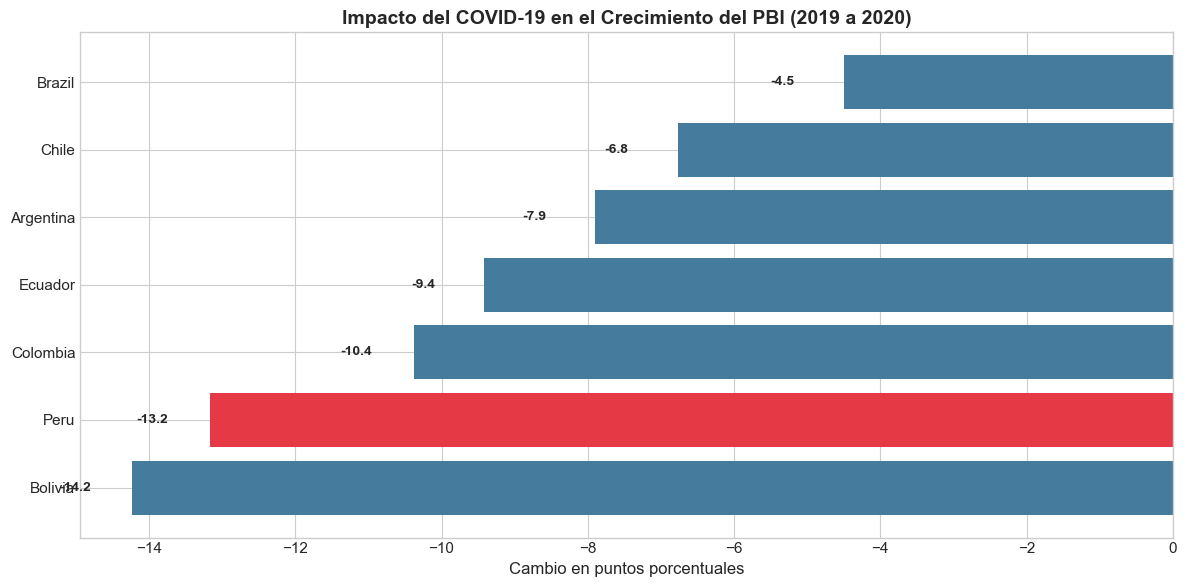

Grafico guardado: 'grafico_impacto_covid.png'


In [80]:
# Grafico de barras: Impacto COVID por pais
if 'Caida_2020' in df_pivot_covid.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    paises = df_pivot_covid.index.tolist()
    caidas = df_pivot_covid['Caida_2020'].values
    
    # Colores: Peru en rojo
    colores = ['#E63946' if p == 'Peru' else '#457B9D' for p in paises]
    
    bars = ax.barh(paises, caidas, color=colores)
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Cambio en puntos porcentuales', fontsize=12)
    ax.set_title('Impacto del COVID-19 en el Crecimiento del PBI (2019 a 2020)', fontsize=14, fontweight='bold')
    
    # Agregar valores en las barras
    for bar, valor in zip(bars, caidas):
        ax.text(valor - 1 if valor < 0 else valor + 0.5, bar.get_y() + bar.get_height()/2,
                f'{valor:.1f}', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('grafico_impacto_covid.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Grafico guardado: 'grafico_impacto_covid.png'")

### 8.2 Comparacion Pre-COVID vs Post-COVID - Grafico de barras agrupadas

In [81]:
# Calcular promedios por fase COVID para Peru
indicadores_comparar = {
    'NY.GDP.PCAP.CD': 'PBI per capita',
    'NY.GDP.MKTP.KD.ZG': 'Crecimiento PBI',
    'SP.DYN.LE00.IN': 'Esperanza vida',
    'IT.NET.USER.ZS': 'Internet',
    'NV.AGR.TOTL.ZS': 'Agricultura'
}

df_peru = df_completo[df_completo['pais'] == 'Peru'].copy()

resultados_fases = []

for codigo, nombre in indicadores_comparar.items():
    df_ind = df_peru[df_peru['indicador_codigo'] == codigo].dropna(subset=['valor'])
    
    if not df_ind.empty:
        pre_covid = df_ind[df_ind['anio'].between(2015, 2019)]['valor'].mean()
        covid = df_ind[df_ind['anio'].between(2020, 2021)]['valor'].mean()
        post_covid = df_ind[df_ind['anio'].between(2022, 2023)]['valor'].mean()
        
        cambio_total = ((post_covid - pre_covid) / pre_covid * 100) if pre_covid != 0 else 0
        
        resultados_fases.append({
            'Indicador': nombre,
            'Pre_COVID': round(pre_covid, 2),
            'COVID': round(covid, 2),
            'Post_COVID': round(post_covid, 2),
            'Cambio_Total_Pct': round(cambio_total, 1)
        })

df_fases_peru = pd.DataFrame(resultados_fases)
print("PERU: Comparacion por Fases COVID")
print("="*80)
display(df_fases_peru)

PERU: Comparacion por Fases COVID


,Indicador,Pre_COVID,COVID,Post_COVID,Cambio_Total_Pct
0,PBI per capita,6640.08,6479.76,7619.09,14.7
1,Crecimiento PBI,3.19,1.21,1.20,-62.3
2,Esperanza vida,75.99,72.71,77.29,1.7
3,Internet,50.35,68.18,77.08,53.1
4,Agricultura,6.90,7.42,7.21,4.5


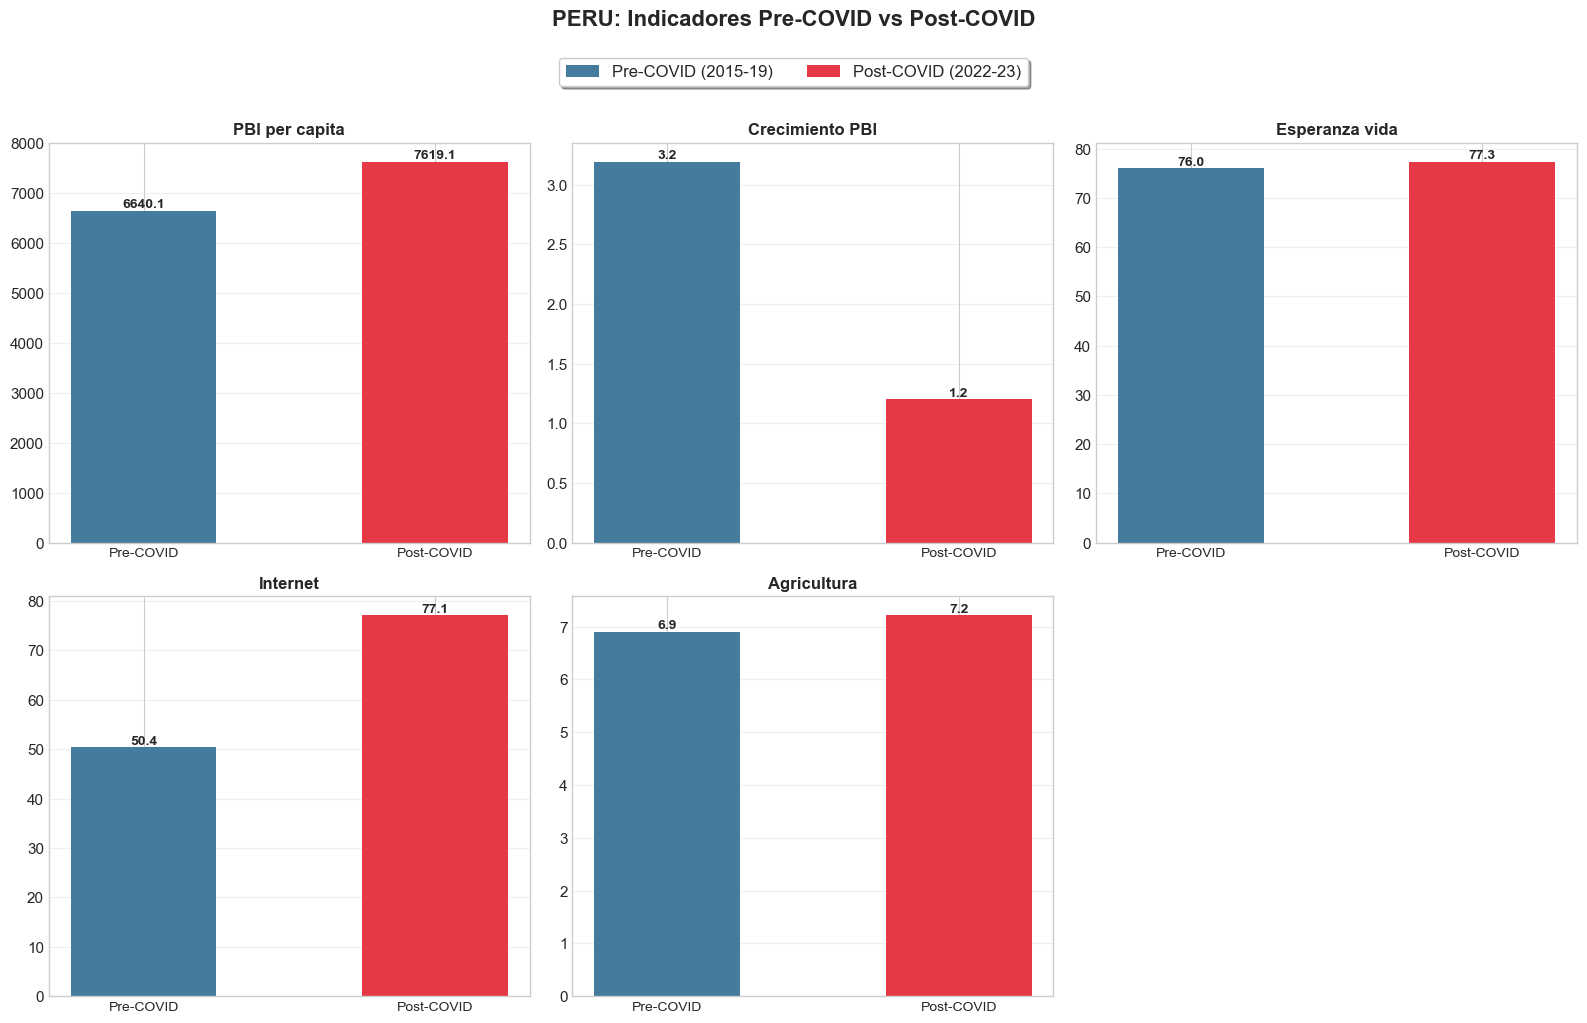

Grafico guardado: 'grafico_pre_post_covid.png'


In [82]:
# Grafico de SUBPLOTS: Pre vs Post COVID (cada indicador con su propia escala)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

indicadores = df_fases_peru['Indicador'].tolist()
pre_covid = df_fases_peru['Pre_COVID'].tolist()
post_covid = df_fases_peru['Post_COVID'].tolist()

# Variable para guardar handles y labels de la leyenda
handles, labels = None, None

for idx, (indicador, pre, post) in enumerate(zip(indicadores, pre_covid, post_covid)):
    ax = axes[idx]
    
    x = np.arange(2)
    width = 0.5
    
    bars1 = ax.bar(x[0], pre, width, label='Pre-COVID (2015-19)', color='#457B9D')
    bars2 = ax.bar(x[1], post, width, label='Post-COVID (2022-23)', color='#E63946')
    
    # Guardar handles para leyenda global
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
    
    # Títulos y etiquetas
    ax.set_title(indicador, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Pre-COVID', 'Post-COVID'], fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Agregar valores sobre las barras
    for bar in [bars1, bars2]:
        height = bar[0].get_height()
        ax.text(bar[0].get_x() + bar[0].get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Ocultar el subplot extra si hay menos de 6 indicadores
if len(indicadores) < 6:
    fig.delaxes(axes[5])

# Leyenda GLOBAL en la parte superior central
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=2, fontsize=12, frameon=True, shadow=True)

plt.suptitle('PERU: Indicadores Pre-COVID vs Post-COVID', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('grafico_pre_post_covid.png', dpi=300, bbox_inches='tight')
plt.show()
print("Grafico guardado: 'grafico_pre_post_covid.png'")


---
## 9. ANALISIS DE TENDENCIAS - Grafico de barras

In [83]:
def calcular_tendencia(df, pais, indicador_codigo):
    """
    Calcula la tendencia lineal de un indicador para un pais.
    """
    df_filtro = df[(df['pais'] == pais) & (df['indicador_codigo'] == indicador_codigo)].copy()
    df_filtro = df_filtro.dropna(subset=['valor']).sort_values('anio')
    
    if len(df_filtro) < 3:
        return None, None
    
    x = df_filtro['anio'].values
    y = df_filtro['valor'].values
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, r_value**2


# Calcular tendencias para PBI per capita
tendencias_pbi = []

for pais in df_completo['pais'].unique():
    slope, r2 = calcular_tendencia(df_completo, pais, 'NY.GDP.PCAP.CD')
    if slope is not None:
        tendencias_pbi.append({'Pais': pais, 'Cambio_anual_USD': round(slope, 2), 'R2': round(r2, 3)})

df_tendencias = pd.DataFrame(tendencias_pbi).sort_values('Cambio_anual_USD', ascending=False)

print("TENDENCIAS: Cambio anual promedio en PBI per capita (USD/anio)")
print("="*60)
display(df_tendencias)

TENDENCIAS: Cambio anual promedio en PBI per capita (USD/anio)


,Pais,Cambio_anual_USD,R2
3,Chile,331.82,0.462
6,Peru,155.98,0.544
1,Bolivia,132.74,0.504
5,Ecuador,60.94,0.207
4,Colombia,53.00,0.085
2,Brazil,10.97,0.001
0,Argentina,-78.18,0.010


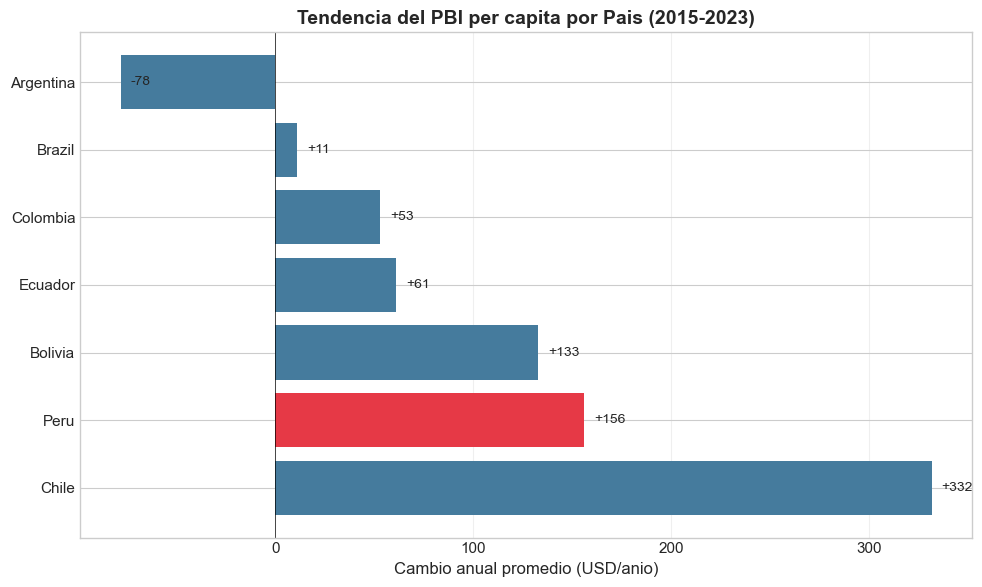

Grafico guardado: 'grafico_tendencias.png'


In [84]:
# Grafico de tendencias
fig, ax = plt.subplots(figsize=(10, 6))

paises = df_tendencias['Pais'].tolist()
cambios = df_tendencias['Cambio_anual_USD'].tolist()

colores = ['#E63946' if p == 'Peru' else '#457B9D' for p in paises]

bars = ax.barh(paises, cambios, color=colores)

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Cambio anual promedio (USD/anio)', fontsize=12)
ax.set_title('Tendencia del PBI per capita por Pais (2015-2023)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for bar, valor in zip(bars, cambios):
    ax.text(valor + 5, bar.get_y() + bar.get_height()/2,
            f'{valor:+.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('grafico_tendencias.png', dpi=300, bbox_inches='tight')
plt.show()
print("Grafico guardado: 'grafico_tendencias.png'")

---
## 10. PROYECCIONES SIMPLES (2024-2026)

In [85]:
def proyectar_indicador(df, pais, indicador_codigo, anios_proyeccion=[2024, 2025, 2026]):
    """
    Realiza una proyeccion lineal simple.
    """
    df_filtro = df[(df['pais'] == pais) & (df['indicador_codigo'] == indicador_codigo)].copy()
    df_filtro = df_filtro.dropna(subset=['valor']).sort_values('anio')
    
    if len(df_filtro) < 3:
        return None
    
    x = df_filtro['anio'].values
    y = df_filtro['valor'].values
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    proyecciones = {}
    for anio in anios_proyeccion:
        proyecciones[anio] = slope * anio + intercept
    
    return proyecciones, slope, r_value**2


# Proyecciones para Peru
print("PROYECCIONES PARA PERU (2024-2026)")
print("Basadas en tendencia lineal 2015-2023")
print("Nota: Proyecciones simplificadas, solo indicativas")
print("="*70)

indicadores_proyeccion = {
    'NY.GDP.PCAP.CD': 'PBI per capita (USD)',
    'SP.DYN.LE00.IN': 'Esperanza de vida (anios)',
    'IT.NET.USER.ZS': 'Usuarios de Internet (%)',
    'SP.DYN.IMRT.IN': 'Mortalidad infantil (por 1000)'
}

proyecciones_peru = []

for codigo, nombre in indicadores_proyeccion.items():
    result = proyectar_indicador(df_completo, 'Peru', codigo)
    
    if result:
        proy, slope, r2 = result
        
        df_peru_ind = df_completo[(df_completo['pais'] == 'Peru') & 
                                   (df_completo['indicador_codigo'] == codigo)].dropna(subset=['valor'])
        ultimo_anio = df_peru_ind['anio'].max()
        ultimo_valor = df_peru_ind[df_peru_ind['anio'] == ultimo_anio]['valor'].values[0]
        
        proyecciones_peru.append({
            'Indicador': nombre,
            'Ultimo_real': round(ultimo_valor, 2),
            'Anio_ultimo': int(ultimo_anio),
            'Proy_2024': round(proy[2024], 2),
            'Proy_2025': round(proy[2025], 2),
            'Proy_2026': round(proy[2026], 2),
            'R2': round(r2, 3)
        })

df_proyecciones = pd.DataFrame(proyecciones_peru)
display(df_proyecciones)

PROYECCIONES PARA PERU (2024-2026)
Basadas en tendencia lineal 2015-2023
Nota: Proyecciones simplificadas, solo indicativas


,Indicador,Ultimo_real,Anio_ultimo,Proy_2024,Proy_2025,Proy_2026,R2
0,PBI per capita (USD),7887.54,2023,7601.93,7757.91,7913.90,0.544
1,Esperanza de vida (anios),77.74,2023,75.53,75.53,75.52,0.000
2,Usuarios de Internet (%),79.48,2023,84.73,89.62,94.52,0.999
3,Mortalidad infantil (por 1000),13.50,2023,13.51,13.38,13.25,0.963


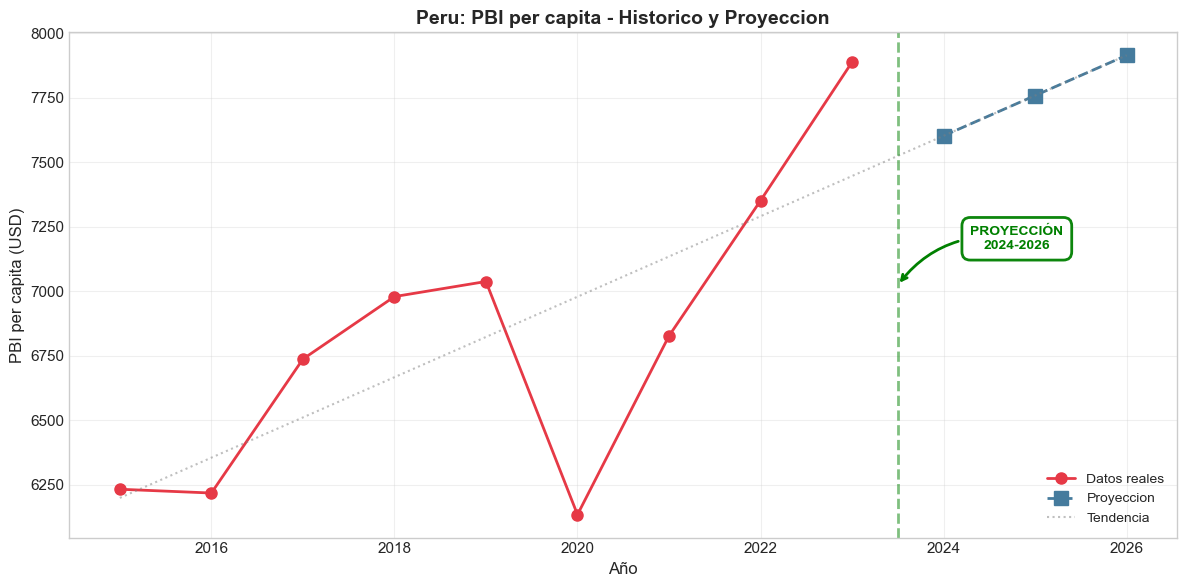

Grafico guardado: 'grafico_proyeccion_peru.png'


In [86]:
# Grafico de proyeccion del PBI per capita de Peru
df_peru_pbi = df_completo[(df_completo['pais'] == 'Peru') & 
                          (df_completo['indicador_codigo'] == 'NY.GDP.PCAP.CD')].copy()
df_peru_pbi = df_peru_pbi.dropna(subset=['valor']).sort_values('anio')

if not df_peru_pbi.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Datos reales
    ax.plot(df_peru_pbi['anio'], df_peru_pbi['valor'], 'o-', 
            color='#E63946', linewidth=2, markersize=8, label='Datos reales')
    
    # Linea de tendencia
    x = df_peru_pbi['anio'].values
    y = df_peru_pbi['valor'].values
    slope, intercept, _, _, _ = stats.linregress(x, y)
    
    # Proyeccion
    anios_proy = [2024, 2025, 2026]
    valores_proy = [slope * anio + intercept for anio in anios_proy]
    
    ax.plot(anios_proy, valores_proy, 's--', color='#457B9D', 
            linewidth=2, markersize=10, label='Proyeccion')
    
    # Linea de tendencia completa
    anios_tendencia = list(range(2015, 2027))
    valores_tendencia = [slope * anio + intercept for anio in anios_tendencia]
    ax.plot(anios_tendencia, valores_tendencia, ':', color='gray', alpha=0.5, label='Tendencia')
    
    # Linea vertical de separacion
    ax.axvline(x=2023.5, color='green', linestyle='--', alpha=0.5, linewidth=2)
    
    # ANOTACIÓN con flecha
    y_limits = ax.get_ylim()
    y_mid = (y_limits[0] + y_limits[1]) / 2
    
    ax.annotate('PROYECCIÓN\n2024-2026', 
                xy=(2023.5, y_mid), 
                xytext=(2024.8, y_limits[1]*0.90),
                fontsize=10, color='green', fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='white', 
                         edgecolor='green', linewidth=2, alpha=0.95),
                arrowprops=dict(arrowstyle='->', color='green', 
                               lw=2, connectionstyle='arc3,rad=0.3'))
    
    ax.set_title('Peru: PBI per capita - Historico y Proyeccion', fontsize=14, fontweight='bold')
    ax.set_xlabel('Año', fontsize=12)
    ax.set_ylabel('PBI per capita (USD)', fontsize=12)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('grafico_proyeccion_peru.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Grafico guardado: 'grafico_proyeccion_peru.png'")


---
## 11. TOP/BOTTOM PERFORMERS - Quien mejoro mas?

In [87]:
def calcular_mejora(df, indicador_codigo, nombre_indicador):
    """
    Calcula la mejora de cada pais entre 2015 y el ultimo anio disponible.
    """
    df_ind = df[df['indicador_codigo'] == indicador_codigo].dropna(subset=['valor'])
    
    mejoras = []
    
    for pais in df_ind['pais'].unique():
        df_pais = df_ind[df_ind['pais'] == pais].sort_values('anio')
        
        if len(df_pais) >= 2:
            primer_valor = df_pais.iloc[0]['valor']
            ultimo_valor = df_pais.iloc[-1]['valor']
            
            cambio_porcentual = ((ultimo_valor - primer_valor) / primer_valor * 100) if primer_valor != 0 else 0
            
            mejoras.append({
                'Pais': pais,
                'Valor_inicial': round(primer_valor, 2),
                'Valor_final': round(ultimo_valor, 2),
                'Cambio_pct': round(cambio_porcentual, 1)
            })
    
    return pd.DataFrame(mejoras).sort_values('Cambio_pct', ascending=False)


# Top performers en PBI per capita
df_mejora_pbi = calcular_mejora(df_completo, 'NY.GDP.PCAP.CD', 'PBI per capita')
print("TOP PERFORMERS: Cambio porcentual en PBI per capita (2015-2023)")
print("="*60)
display(df_mejora_pbi)

TOP PERFORMERS: Cambio porcentual en PBI per capita (2015-2023)


,Pais,Valor_inicial,Valor_final,Cambio_pct
1,Bolivia,2996.01,4274.71,42.7
3,Chile,13433.92,17067.04,27.0
6,Peru,6231.71,7887.54,26.6
2,Brazil,8936.20,10377.59,16.1
5,Ecuador,5976.16,6737.85,12.7
4,Colombia,6248.51,7000.84,12.0
0,Argentina,13679.63,14261.85,4.3


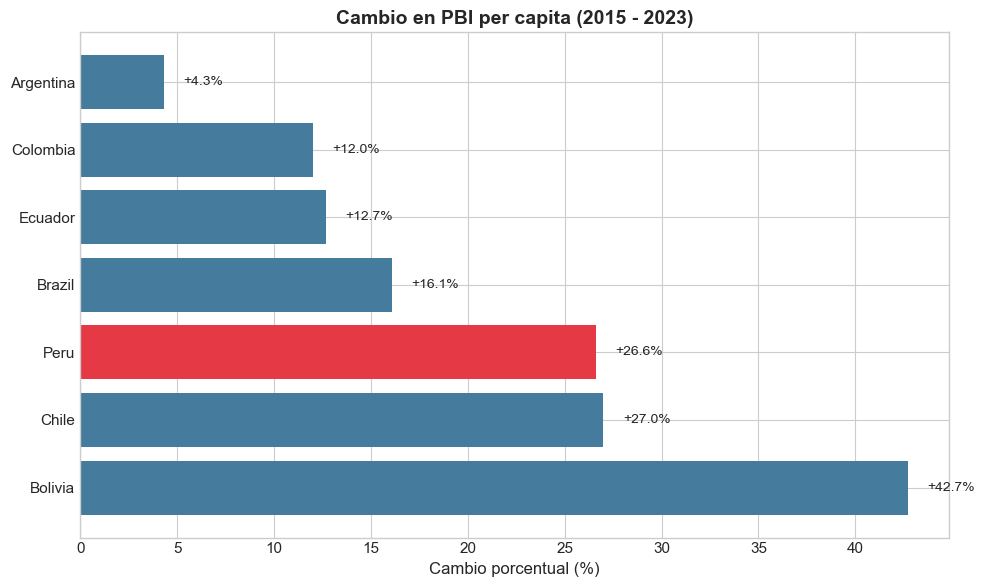

Grafico guardado: 'grafico_mejora_pbi.png'


In [88]:
# Grafico: Mejora en PBI per capita
fig, ax = plt.subplots(figsize=(10, 6))

paises = df_mejora_pbi['Pais'].tolist()
cambios = df_mejora_pbi['Cambio_pct'].tolist()

colores = ['#E63946' if p == 'Peru' else '#457B9D' for p in paises]

bars = ax.barh(paises, cambios, color=colores)

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Cambio porcentual (%)', fontsize=12)
ax.set_title('Cambio en PBI per capita (2015 - 2023)', fontsize=14, fontweight='bold')

for bar, valor in zip(bars, cambios):
    ax.text(valor + 1, bar.get_y() + bar.get_height()/2,
            f'{valor:+.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('grafico_mejora_pbi.png', dpi=300, bbox_inches='tight')
plt.show()
print("Grafico guardado: 'grafico_mejora_pbi.png'")

---
## 12. RESUMEN EJECUTIVO: Posicion de Peru - Heatmap

In [89]:
def obtener_ranking_peru(df, indicador_codigo, mayor_es_mejor=True):
    """
    Obtiene el ranking de Peru en un indicador.
    """
    df_ind = df[df['indicador_codigo'] == indicador_codigo].dropna(subset=['valor'])
    ultimo_dato = df_ind.loc[df_ind.groupby('pais')['anio'].idxmax()]
    
    if mayor_es_mejor:
        ultimo_dato = ultimo_dato.sort_values('valor', ascending=False)
    else:
        ultimo_dato = ultimo_dato.sort_values('valor', ascending=True)
    
    ultimo_dato = ultimo_dato.reset_index(drop=True)
    ultimo_dato['ranking'] = range(1, len(ultimo_dato) + 1)
    
    peru_rank = ultimo_dato[ultimo_dato['pais'] == 'Peru']
    
    if not peru_rank.empty:
        return peru_rank['ranking'].values[0], len(ultimo_dato), peru_rank['valor'].values[0]
    return None, None, None


# ---
# ## 12. RESUMEN EJECUTIVO: Posicion de Peru

# Calcular el ranking de Peru en cada indicador (datos más recientes disponibles)
indicadores_ranking = {
    'NY.GDP.PCAP.CD': 'PBI per capita',
    'NY.GDP.MKTP.KD.ZG': 'Crecimiento PBI',
    'SP.DYN.LE00.IN': 'Esperanza de vida',
    'SP.DYN.IMRT.IN': 'Mortalidad infantil',
    'IT.NET.USER.ZS': 'Acceso a Internet',
    'SE.XPD.TOTL.GD.ZS': 'Gasto en Educacion',
    'NV.AGR.TOTL.ZS': 'Agricultura (% PBI)',
    'SI.POV.GINI': 'Desigualdad (GINI)'
}

ranking_resultados = []

for codigo, nombre in indicadores_ranking.items():
    # Filtrar datos del indicador
    df_ind = df_completo[df_completo['indicador_codigo'] == codigo].copy()
    df_ind = df_ind.dropna(subset=['valor'])
    
    if df_ind.empty:
        continue
    
    # Obtener el año más reciente disponible
    ultimo_anio = df_ind['anio'].max()
    df_ultimo = df_ind[df_ind['anio'] == ultimo_anio].copy()
    
    # Calcular ranking (1 = mejor)
    # Para mortalidad infantil y GINI: menor es mejor
    if codigo in ['SP.DYN.IMRT.IN', 'SI.POV.GINI']:
        df_ultimo['rank'] = df_ultimo['valor'].rank(method='min', ascending=True)
    else:
        df_ultimo['rank'] = df_ultimo['valor'].rank(method='min', ascending=False)
    
    # Obtener el ranking de Peru
    peru_data = df_ultimo[df_ultimo['pais'] == 'Peru']
    
    if not peru_data.empty:
        ranking_resultados.append({
            'Indicador': nombre,
            'Ranking': int(peru_data['rank'].values[0]),
            'Valor_2023': round(peru_data['valor'].values[0], 2),
            'Anio': int(ultimo_anio)
        })

# Crear DataFrame con los rankings
df_ranking_peru = pd.DataFrame(ranking_resultados)
df_ranking_peru = df_ranking_peru.sort_values('Ranking')

print("RESUMEN EJECUTIVO: Posicion de Peru en cada indicador")
print("="*70)
display(df_ranking_peru)


RESUMEN EJECUTIVO: Posicion de Peru en cada indicador


,Indicador,Ranking,Valor_2023,Anio
7,Desigualdad (GINI),1,40.70,2023
2,Esperanza de vida,2,77.74,2023
5,Gasto en Educacion,3,4.24,2023
0,PBI per capita,4,7887.54,2023
4,Acceso a Internet,4,79.48,2023
6,Agricultura (% PBI),4,7.24,2023
3,Mortalidad infantil,6,13.50,2023
1,Crecimiento PBI,6,-0.40,2023


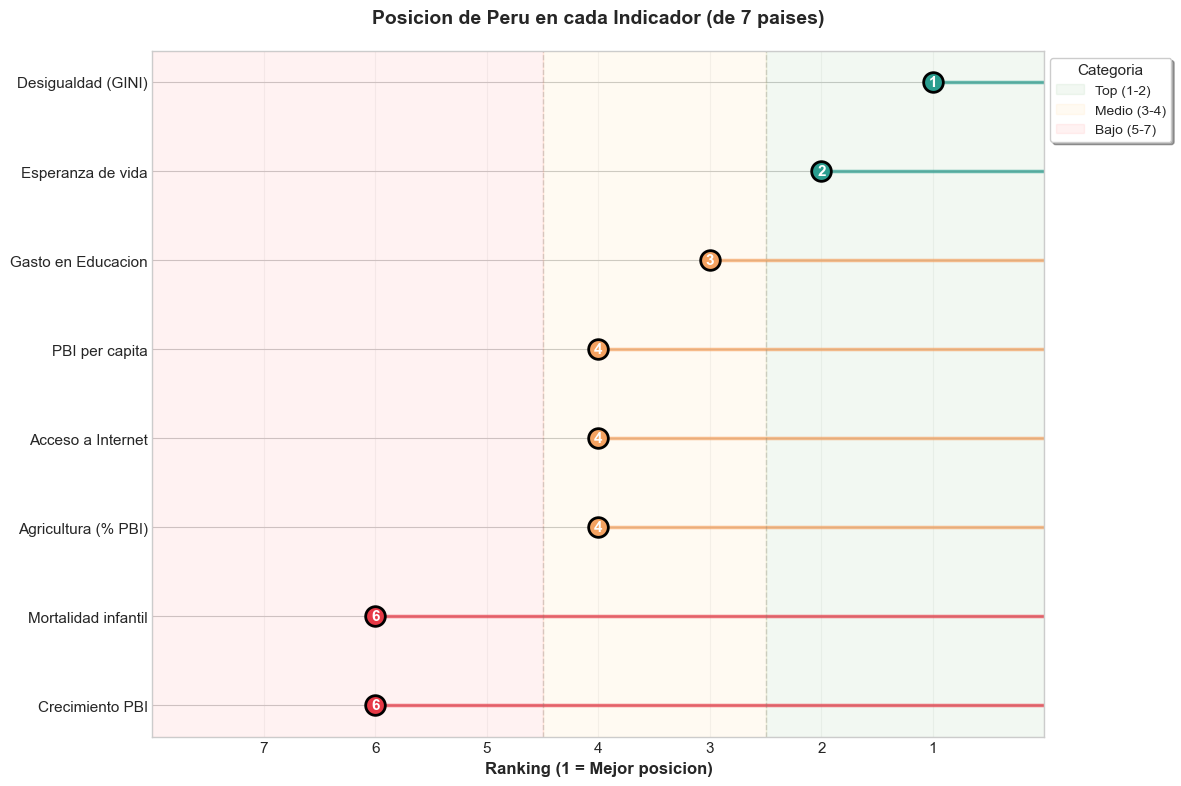

Grafico guardado: 'grafico_ranking_peru.png'


In [90]:
# GRAFICO MEJORADO: Lollipop chart con colores por tier
fig, ax = plt.subplots(figsize=(12, 8))

# Datos del ranking
indicadores_rank = df_ranking_peru['Indicador'].tolist()
rankings = df_ranking_peru['Ranking'].tolist()

# Invertir para que mejor esté arriba
indicadores_rank = indicadores_rank[::-1]
rankings = rankings[::-1]

# Colores según tier
colores = []
for rank in rankings:
    if rank <= 2:
        colores.append('#2A9D8F')  # Verde (Top)
    elif rank <= 4:
        colores.append('#F4A261')  # Amarillo/Naranja (Medio)
    else:
        colores.append('#E63946')  # Rojo (Bajo)

y_pos = np.arange(len(indicadores_rank))

# Crear lollipops
for i, (y, x, color) in enumerate(zip(y_pos, rankings, colores)):
    ax.plot([0, x], [y, y], color=color, linewidth=2.5, alpha=0.7)
    ax.scatter(x, y, color=color, s=200, zorder=3, edgecolors='black', linewidth=2)

# Etiquetas de ranking dentro de los círculos
for i, (y, x) in enumerate(zip(y_pos, rankings)):
    ax.text(x, y, f'{int(x)}', ha='center', va='center', 
            fontsize=11, fontweight='bold', color='white')

# Etiquetas de indicador
ax.set_yticks(y_pos)
ax.set_yticklabels(indicadores_rank, fontsize=11)

# Configuración del eje X (invertido: 1 es mejor)
ax.set_xlim(8, 0)
ax.set_xlabel('Ranking (1 = Mejor posicion)', fontsize=12, fontweight='bold')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_title('Posicion de Peru en cada Indicador (de 7 paises)', 
             fontsize=14, fontweight='bold', pad=20)

# Líneas verticales de referencia
ax.axvline(x=2.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax.axvline(x=4.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)

# Áreas de fondo
ax.axvspan(0, 2.5, alpha=0.05, color='green', label='Top (1-2)')
ax.axvspan(2.5, 4.5, alpha=0.05, color='orange', label='Medio (3-4)')
ax.axvspan(4.5, 8, alpha=0.05, color='red', label='Bajo (5-7)')

# Leyenda FUERA del gráfico
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1), 
          fontsize=10, frameon=True, shadow=True, title='Categoria')

ax.grid(True, alpha=0.2, axis='x')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('grafico_ranking_peru.png', dpi=300, bbox_inches='tight')
plt.show()
print("Grafico guardado: 'grafico_ranking_peru.png'")


In [104]:
# ---
# ### 12.5 Resumen Ejecutivo en Numeros

print("RESUMEN EJECUTIVO: Peru en Numeros Clave")
print("="*80)
print()

# FORTALEZAS
print("✅ FORTALEZAS DE PERU:")
print("-" * 80)
fortalezas = pd.DataFrame({
    'Indicador': [
        'Desigualdad (GINI)',
        'Esperanza de vida',
        'Mejora en Internet',
        'Rebote post-COVID'
    ],
    'Valor': [
        '40.70',
        '77.74 años',
        '+94.6%',
        '+24.29 p.p.'
    ],
    'Ranking': [
        '1° de 7',
        '2° de 7',
        '1° de 7',
        '1° de 7'
    ]
})
# Resetear índice para que empiece en 1
fortalezas.index = range(1, len(fortalezas) + 1)
display(fortalezas)

print()
print("⚠️ AREAS DE MEJORA:")
print("-" * 80)
debilidades = pd.DataFrame({
    'Indicador': [
        'Crecimiento PBI 2023',
        'Mortalidad infantil',
        'Gasto en educacion',
        'Caida COVID 2020'
    ],
    'Valor': [
        '-0.40%',
        '13.5 por 1000',
        '4.24% del PBI',
        '-13.17 p.p.'
    ],
    'Ranking': [
        '6° de 7',
        '6° de 7',
        '6° de 7',
        '7° de 7'
    ]
})
# Resetear índice para que empiece en 1
debilidades.index = range(1, len(debilidades) + 1)
display(debilidades)

print()
print("📈 POSICION GENERAL:")
print("-" * 80)
general = pd.DataFrame({
    'Aspecto': [
        'PBI per capita 2023',
        'Crecimiento 2015-2023',
        'Tendencia anual',
        'Proyeccion 2026'
    ],
    'Valor': [
        'USD 7,887.54',
        '+26.6%',
        '+155.98 USD/año',
        '~USD 8,500'
    ],
    'Posicion': [
        '4° de 7 (MEDIO)',
        '2° de 7 (MUY BUENO)',
        '2° de 7 (MUY BUENO)',
        '4° de 7 estimado'
    ]
})
# Resetear índice para que empiece en 1
general.index = range(1, len(general) + 1)
display(general)

print()
print("🎯 MENSAJE CLAVE:")
print("Peru destaca en equidad social y desarrollo humano, pero necesita")
print("mejorar su crecimiento economico sostenido y servicios publicos basicos.")


RESUMEN EJECUTIVO: Peru en Numeros Clave

✅ FORTALEZAS DE PERU:
--------------------------------------------------------------------------------


,Indicador,Valor,Ranking
1,Desigualdad (GINI),40.70,1° de 7
2,Esperanza de vida,77.74 años,2° de 7
3,Mejora en Internet,+94.6%,1° de 7
4,Rebote post-COVID,+24.29 p.p.,1° de 7



⚠️ AREAS DE MEJORA:
--------------------------------------------------------------------------------


,Indicador,Valor,Ranking
1,Crecimiento PBI 2023,-0.40%,6° de 7
2,Mortalidad infantil,13.5 por 1000,6° de 7
3,Gasto en educacion,4.24% del PBI,6° de 7
4,Caida COVID 2020,-13.17 p.p.,7° de 7



📈 POSICION GENERAL:
--------------------------------------------------------------------------------


,Aspecto,Valor,Posicion
1,PBI per capita 2023,"USD 7,887.54",4° de 7 (MEDIO)
2,Crecimiento 2015-2023,+26.6%,2° de 7 (MUY BUENO)
3,Tendencia anual,+155.98 USD/año,2° de 7 (MUY BUENO)
4,Proyeccion 2026,"~USD 8,500",4° de 7 estimado



🎯 MENSAJE CLAVE:
Peru destaca en equidad social y desarrollo humano, pero necesita
mejorar su crecimiento economico sostenido y servicios publicos basicos.


---
## 13. ESTADISTICAS ADICIONALES

### 13.1 Boxplots comparativos por pais

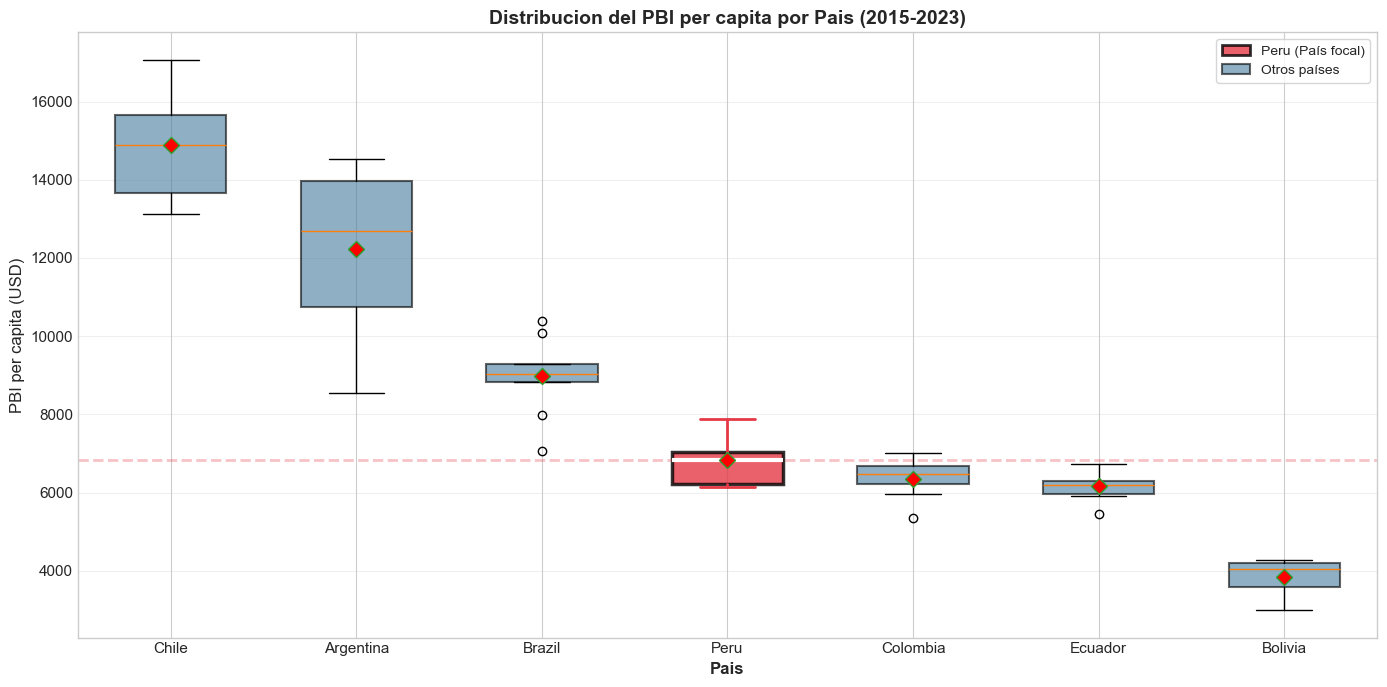

Grafico guardado: 'grafico_boxplot_pbi.png'

ESTADISTICAS DEL BOXPLOT:


,Minimo,Q1 (25%),Mediana,Q3 (75%),Maximo
pais,,,,,
Chile,13114.82,13649.85,14879.91,15659.48,17067.04
Argentina,8535.60,10738.02,12699.96,13962.19,14532.50
Brazil,7074.19,8836.29,9029.83,9300.66,10377.59
Peru,6133.33,6231.71,6826.20,7037.01,7887.54
Colombia,5339.69,6222.62,6472.55,6680.45,7000.84
Ecuador,5463.65,5976.16,6205.06,6303.92,6737.85
Bolivia,2996.01,3580.97,4048.40,4206.86,4274.71


In [94]:
# Boxplot de PBI per capita por pais con Peru destacado
df_pbi = df_completo[df_completo['indicador_codigo'] == 'NY.GDP.PCAP.CD'].copy()
df_pbi = df_pbi.dropna(subset=['valor'])

# Ordenar por mediana
medianas = df_pbi.groupby('pais')['valor'].median().sort_values(ascending=False)
orden_paises = medianas.index.tolist()

fig, ax = plt.subplots(figsize=(14, 7))

# Preparar datos para boxplot manual (más control)
datos_por_pais = [df_pbi[df_pbi['pais'] == pais]['valor'].values for pais in orden_paises]

# Crear boxplot
bp = ax.boxplot(datos_por_pais, 
                labels=orden_paises,
                patch_artist=True,  # Permite colorear las cajas
                widths=0.6,
                showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Colorear las cajas: Peru en rojo, resto en azul
for i, (patch, pais) in enumerate(zip(bp['boxes'], orden_paises)):
    if pais == 'Peru':
        patch.set_facecolor('#E63946')
        patch.set_alpha(0.8)
        patch.set_edgecolor('black')
        patch.set_linewidth(2.5)
    else:
        patch.set_facecolor('#457B9D')
        patch.set_alpha(0.6)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

# Destacar las líneas de Peru
for i, pais in enumerate(orden_paises):
    if pais == 'Peru':
        # Mediana
        bp['medians'][i].set_color('white')
        bp['medians'][i].set_linewidth(3)
        # Bigotes
        bp['whiskers'][i*2].set_color('#E63946')
        bp['whiskers'][i*2].set_linewidth(2)
        bp['whiskers'][i*2+1].set_color('#E63946')
        bp['whiskers'][i*2+1].set_linewidth(2)
        # Caps
        bp['caps'][i*2].set_color('#E63946')
        bp['caps'][i*2].set_linewidth(2)
        bp['caps'][i*2+1].set_color('#E63946')
        bp['caps'][i*2+1].set_linewidth(2)

# Etiquetas y título
ax.set_title('Distribucion del PBI per capita por Pais (2015-2023)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Pais', fontsize=12, fontweight='bold')
ax.set_ylabel('PBI per capita (USD)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Añadir línea horizontal en la mediana de Peru para referencia
mediana_peru = df_pbi[df_pbi['pais'] == 'Peru']['valor'].median()
ax.axhline(y=mediana_peru, color='#E63946', linestyle='--', 
           alpha=0.3, linewidth=2, label=f'Mediana Peru: ${mediana_peru:,.0f}')

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#E63946', label='Peru (País focal)', 
          edgecolor='black', linewidth=2, alpha=0.8),
    Patch(facecolor='#457B9D', label='Otros países', 
          edgecolor='black', linewidth=1.5, alpha=0.6)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig('grafico_boxplot_pbi.png', dpi=300, bbox_inches='tight')
plt.show()
print("Grafico guardado: 'grafico_boxplot_pbi.png'")

# Mostrar estadísticas del boxplot
print("\nESTADISTICAS DEL BOXPLOT:")
print("="*70)
stats_boxplot = df_pbi.groupby('pais')['valor'].describe()[['min', '25%', '50%', '75%', 'max']]
stats_boxplot.columns = ['Minimo', 'Q1 (25%)', 'Mediana', 'Q3 (75%)', 'Maximo']
stats_boxplot = stats_boxplot.loc[orden_paises].round(2)
display(stats_boxplot)


### 13.2 Matriz de correlacion entre indicadores

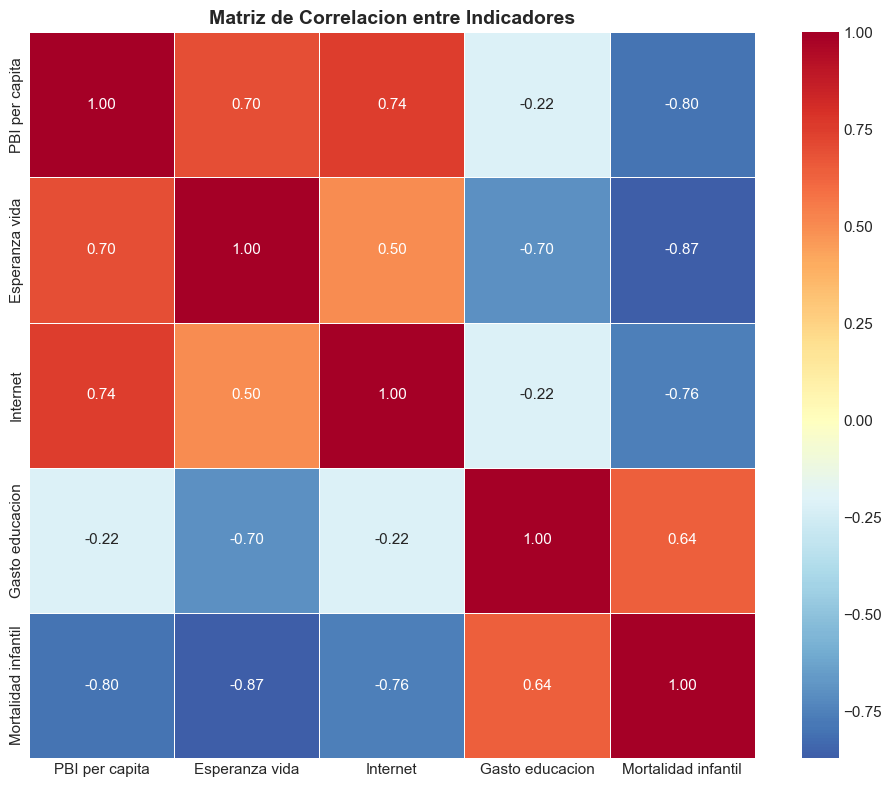

Grafico guardado: 'grafico_correlacion.png'


In [92]:
# Crear tabla pivote para correlaciones
df_pivot = df_completo.pivot_table(
    index=['pais', 'anio'],
    columns='indicador_codigo',
    values='valor'
).reset_index()

# Seleccionar indicadores principales
indicadores_corr = ['NY.GDP.PCAP.CD', 'SP.DYN.LE00.IN', 'IT.NET.USER.ZS', 
                    'SE.XPD.TOTL.GD.ZS', 'SP.DYN.IMRT.IN']

nombres_corr = ['PBI per capita', 'Esperanza vida', 'Internet', 'Gasto educacion', 'Mortalidad infantil']

# Filtrar columnas existentes
indicadores_existentes = [i for i in indicadores_corr if i in df_pivot.columns]

if len(indicadores_existentes) > 1:
    df_corr = df_pivot[indicadores_existentes].corr()
    df_corr.index = nombres_corr[:len(indicadores_existentes)]
    df_corr.columns = nombres_corr[:len(indicadores_existentes)]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df_corr, annot=True, cmap='RdYlBu_r', center=0,
                square=True, linewidths=0.5, fmt='.2f', ax=ax)
    ax.set_title('Matriz de Correlacion entre Indicadores', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('grafico_correlacion.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Grafico guardado: 'grafico_correlacion.png'")

### 13.3 Estadisticas descriptivas completas

In [93]:
# Estadisticas descriptivas por pais para PBI per capita
df_pbi = df_completo[df_completo['indicador_codigo'] == 'NY.GDP.PCAP.CD'].copy()

stats_pbi = df_pbi.groupby('pais')['valor'].agg([
    ('Media', 'mean'),
    ('Mediana', 'median'),
    ('Desv_Std', 'std'),
    ('Minimo', 'min'),
    ('Maximo', 'max'),
    ('Rango', lambda x: x.max() - x.min())
]).round(2)

stats_pbi = stats_pbi.sort_values('Media', ascending=False)

print("ESTADISTICAS DESCRIPTIVAS: PBI per capita (USD)")
print("="*80)
display(stats_pbi)

ESTADISTICAS DESCRIPTIVAS: PBI per capita (USD)


,Media,Mediana,Desv_Std,Minimo,Maximo,Rango
pais,,,,,,
Chile,14879.24,14879.91,1336.76,13114.82,17067.04,3952.22
Argentina,12235.39,12699.96,2122.08,8535.60,14532.50,5996.90
Brazil,8987.68,9029.83,1001.85,7074.19,10377.59,3303.40
Peru,6822.01,6826.20,578.97,6133.33,7887.54,1754.22
Colombia,6357.89,6472.55,497.69,5339.69,7000.84,1661.15
Ecuador,6157.17,6205.06,366.67,5463.65,6737.85,1274.20
Bolivia,3841.80,4048.40,512.11,2996.01,4274.71,1278.70


---
## 14. Conclusiones

### Principales hallazgos:

**1. Posicion economica de Peru:**
- Peru ocupa el **4to lugar** de 7 paises en PBI per capita con USD 7,887.54 (2023)
- Esta por debajo de Chile, Argentina y Brasil, pero supera a Colombia, Ecuador y Bolivia
- Mostro un crecimiento del **+26.6%** en PBI per capita entre 2015 y 2023, ubicandose 2do en mejora porcentual

**2. Impacto del COVID-19:**
- Peru tuvo la **mayor caida del PBI** en la region: -13.17 puntos porcentuales entre 2019 y 2020
- Paso de crecer +2.24% en 2019 a caer -10.93% en 2020
- Tuvo el **mayor rebote en 2021**: +24.29 puntos (de -10.93% a +13.36%)
- Brasil fue el menos afectado con solo -4.50 puntos de caida

**3. Recuperacion post-pandemia:**
- En 2023, Peru registro crecimiento negativo (-0.40%), ubicandose 6to de 7 paises
- Solo Argentina tuvo peor desempenio (-1.61%)
- La recuperacion no ha sido sostenida como en Brasil (+3.24%) o Bolivia (+3.08%)

**4. Tendencias y proyecciones:**
- Peru tiene una tendencia positiva de +155.98 USD/anio en PBI per capita
- Proyeccion para 2026: aproximadamente USD 8,500 per capita
- El acceso a internet crecio +94.6% (de 40.9% a 79.5%), el mayor avance de la region

**5. Fortalezas de Peru:**
- **1ro en menor desigualdad** (GINI = 40.70) - el mas equitativo de la region
- **2do en esperanza de vida** (77.74 anios) - solo detras de Chile
- **1ro en mejora de acceso a internet** (+94.6%)
- **1ro en mejora de esperanza de vida** (+2.7%)

**6. Areas de mejora:**
- **6to en crecimiento del PBI** (2023): economia estancada
- **6to en mortalidad infantil** (13.5 por 1000): solo supera a Bolivia
- **6to en gasto en educacion** (4.24% del PBI): inversion insuficiente

**7. Comparacion con el promedio regional:**
- Peru esta ligeramente por debajo del promedio en PBI per capita
- Supera el promedio en esperanza de vida y acceso a internet
- Esta significativamente por debajo en gasto educativo

### Recomendaciones:

1. **Diversificar la economia** para reducir vulnerabilidad ante shocks externos
2. **Aumentar inversion en educacion** del 4.24% a al menos 5.5% del PBI
3. **Mejorar sistema de salud** para reducir mortalidad infantil
4. **Capitalizar la conectividad digital** para impulsar productividad
5. **Mantener politicas de reduccion de desigualdad** que han sido exitosas

---

## 15. Referencias

- World Bank Open Data: https://data.worldbank.org/
- API Documentation: https://datahelpdesk.worldbank.org/knowledgebase/articles/889392
- Indicadores del World Bank: https://data.worldbank.org/indicator